### Table of Contents

- [skip to training the small purchase model](#Small-Train)
- [skip to training the large purchase model](#Large-Train)
- [XGBoost with standard dataset](#XGBoost-Model-standard-dataset)
- [XGBoost with summary dataset](#XGBoost-Model-summary-dataset)
- [Model Evaluation](#Model-Evaluation)

In [10]:
import pandas as pd
import numpy as np


#visualizations libraries
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('bmh')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

#machine learning libraries
import xgboost as xgb
import catboost as cb 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

from matplotlib import patheffects


import os


#project modules
import src.wrangle as wr
import src.wrangle_copy as wrc
import src.summaries as s
import src.explore as ex


pd.options.display.float_format = '{:,.2f}'.format
from importlib import reload

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


In [3]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

## time series at a glance

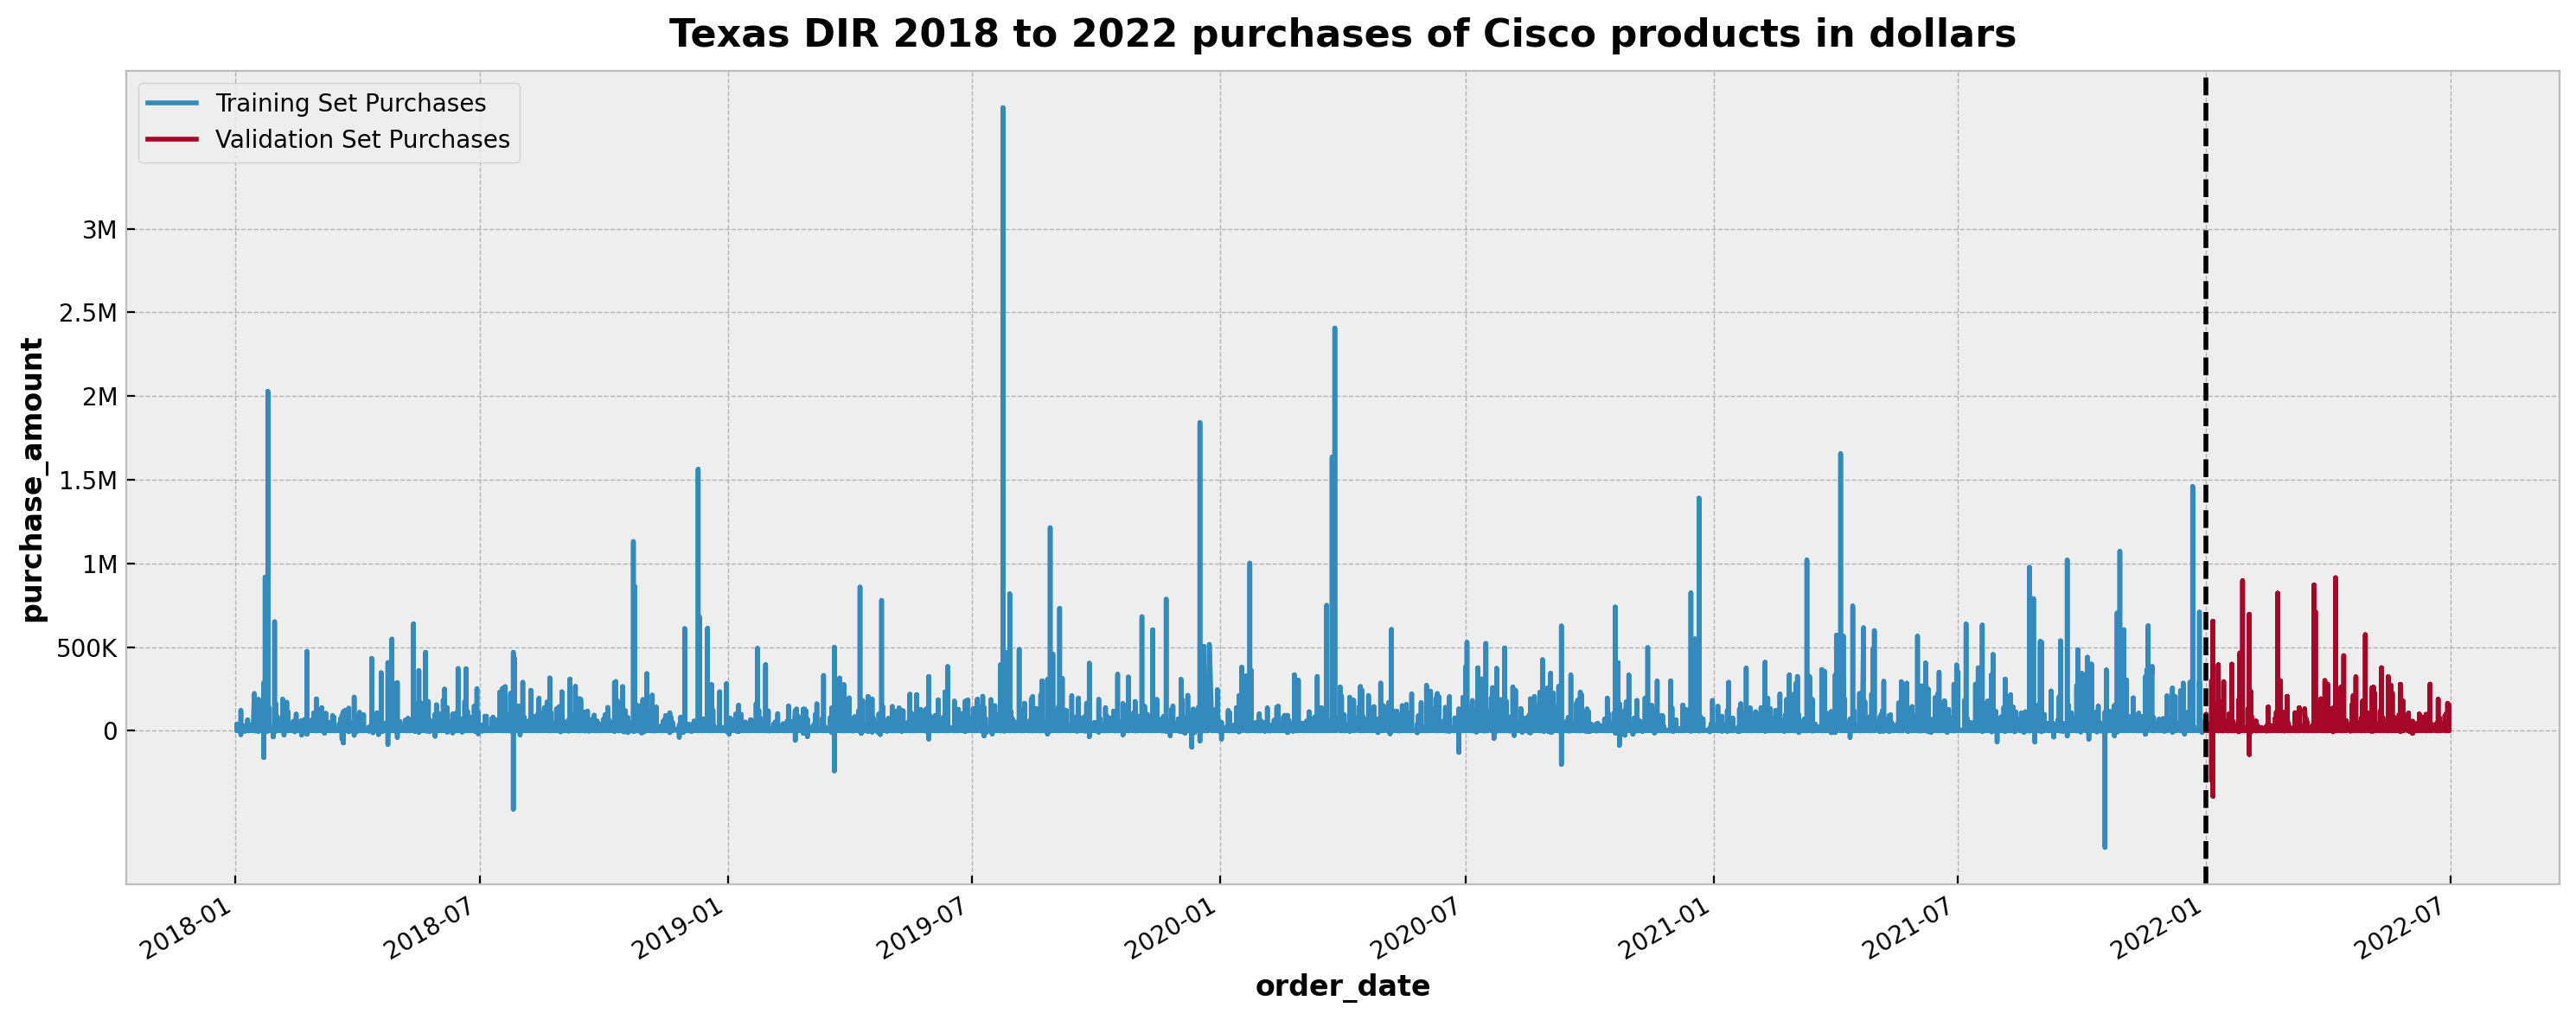

In [ ]:
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

train = train.drop(train[train['order_quantity'] > 94_000_000].index )

fix, ax = plt.subplots(figsize = (15,6))
train['purchase_amount'].plot(ax = ax, label='Training Set', title='Texas DIR 2018 to 2022 purchases of Cisco products in dollars')
validate['purchase_amount'].plot(ax = ax, label='Validation Set')
#test['purchase_amount'].plot(ax = ax, label='Test Set')
ax.axvline('01-01-22', color='black', ls='--')

ax.legend(['Training Set Purchases', 'Validation Set Purchases'])
ax.set(yticks=[0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000])
ax.set(yticklabels=['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M'])
ax.set(ylabel='purchase_amount') 

#ax.legend(['Training Set', 'Validation Set', 'Test Set'])
plt.show()

In [4]:
df['order_date_copy'] = df.index

In [13]:
df = s.get_summary_df(wrc.get_clean_data(start2018=False))
df = wrc.drop2017_and_move2016_up(df)

train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

In [19]:
train[train.index == '10-24-2019'].sort_values(by = 'purchase_amount', ascending = False)
#train.index = ['2022-10-24']

,customer_name,customer_type,customer_city,reseller_name,shipped_date,year,quarter,month,week,day_of_week,day_of_year,month_name,day_name,purchase_amount
order_date,,,,,,,,,,,,,,
2019-10-24,Joshua Independent School District,K-12,Joshua,"Pivot Solutions, North America, Inc. dba Sigma...",2020-01-21,2019,4,10,43,3,297,October,Thursday,"245,816.30"
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",2020-07-02,2019,4,10,43,3,297,October,Thursday,"132,301.43"
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",2019-11-08,2019,4,10,43,3,297,October,Thursday,"110,000.00"
2019-10-24,Georgetown Independent School District,K-12,Georgetown,CDW Government LLC,2019-11-04,2019,4,10,43,3,297,October,Thursday,"80,028.60"
2019-10-24,Nueces County,Local Government,Corpus Christi,"Insight Public Sector, Inc.",2019-10-26,2019,4,10,43,3,297,October,Thursday,"50,783.70"
2019-10-24,Texas Department of Transportation,State Agency,Austin,"Presidio Networked Solutions Group, LLC",2019-11-12,2019,4,10,43,3,297,October,Thursday,"42,674.56"
2019-10-24,Responsive Education Solutions School District,K-12,Lewisville,CDW Government LLC,2019-10-30,2019,4,10,43,3,297,October,Thursday,"34,794.24"
2019-10-24,Texas Health and Human Services Commission,State Agency,Austin,"Insight Public Sector, Inc.",2020-07-21,2019,4,10,43,3,297,October,Thursday,"31,125.67"
2019-10-24,City of McKinney,Local Government,Mckinney,"Pivot Solutions, North America, Inc. dba Sigma...",2019-11-05,2019,4,10,43,3,297,October,Thursday,"25,257.82"


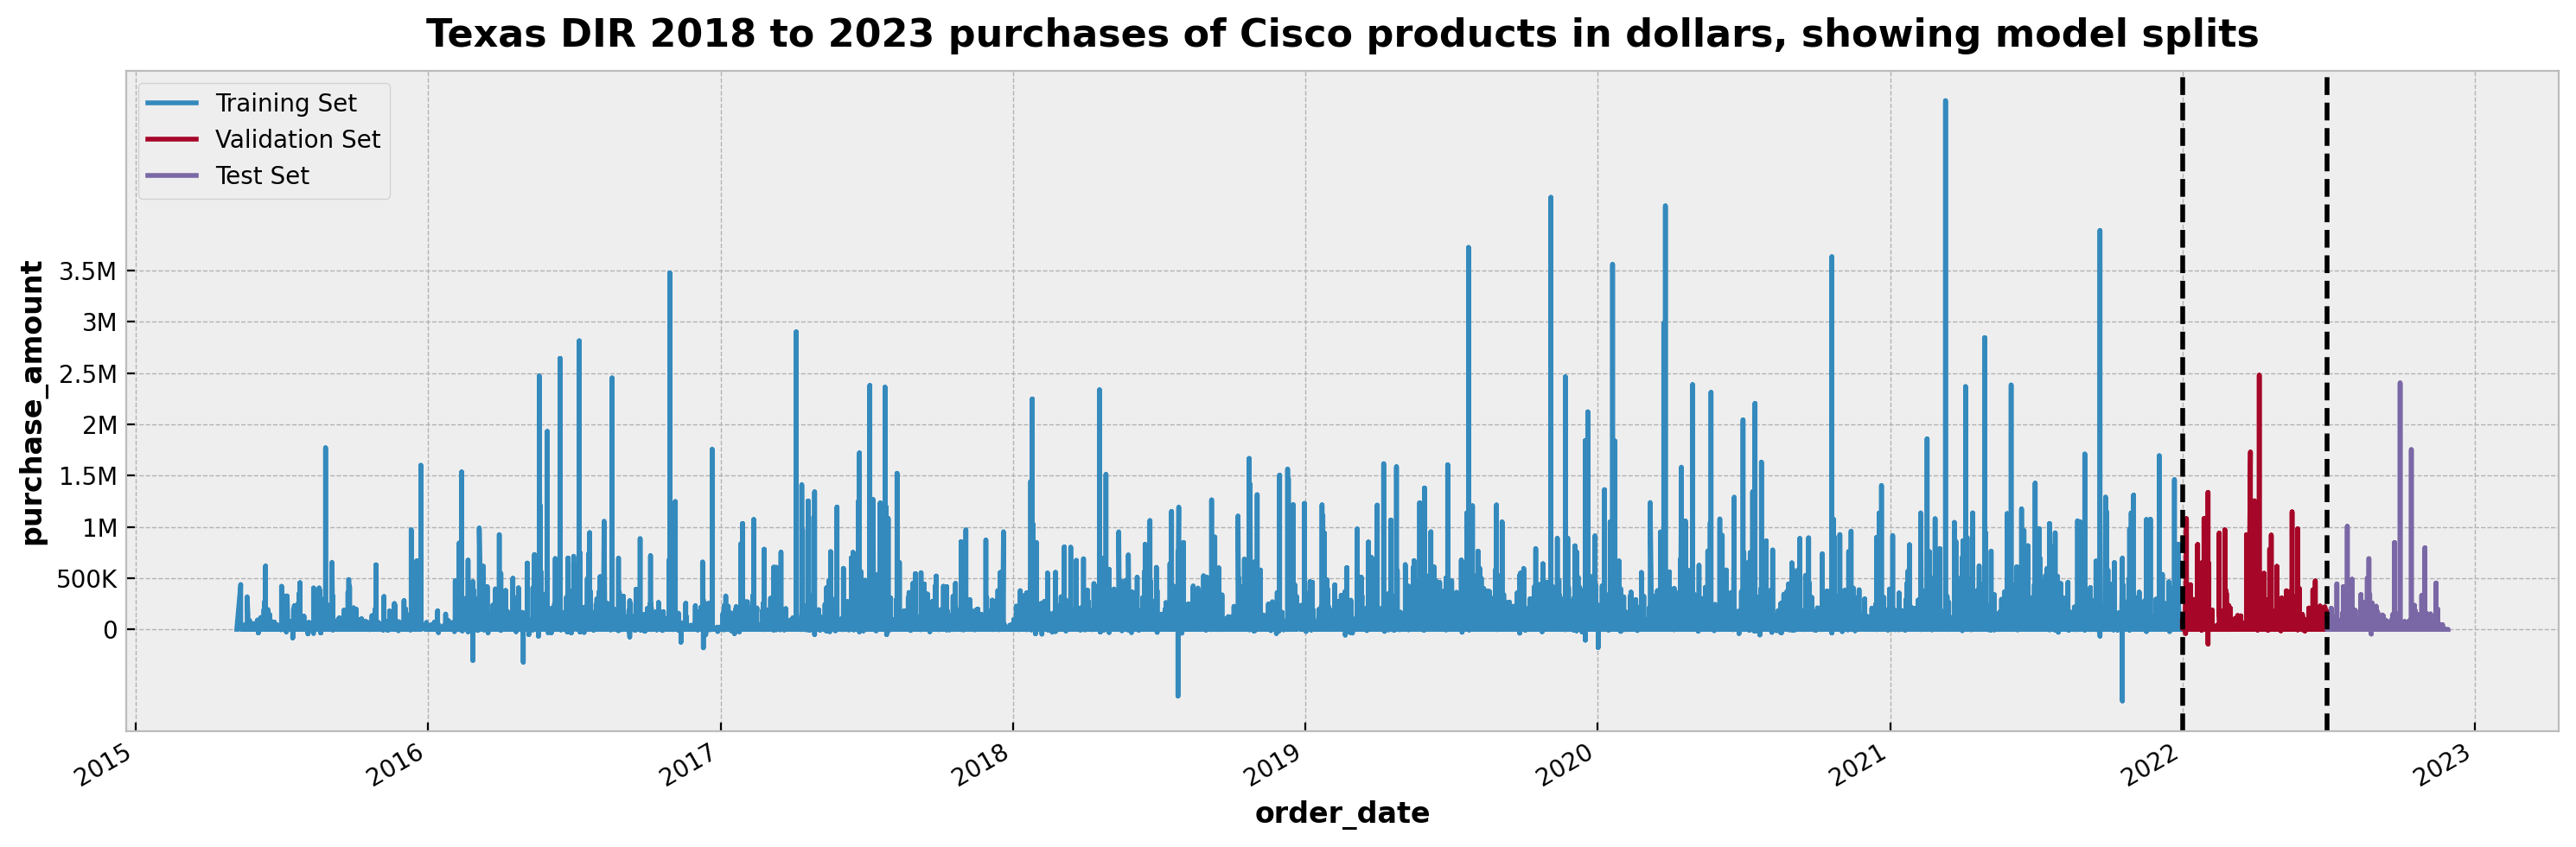

In [20]:
df = s.get_summary_df(wrc.get_clean_data(start2018=False))
df = wrc.drop2017_and_move2016_up(df)

train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

#train = train.drop(train[train['order_quantity'] > 94_000_000].index )


fix, ax = plt.subplots(figsize = (15,5))
train['purchase_amount'].plot(ax = ax, label='Training Set', title='Texas DIR 204 to 2023 purchases of Cisco products in dollars , showing model splits')
validate['purchase_amount'].plot(ax = ax, label='Validation Set')
test['purchase_amount'].plot(ax = ax, label='Test Set')
ax.axvline('01-01-22', color='black', ls='--')
ax.axvline('07-01-22', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])

ax.set(yticks=[0, 500_000, 1_000_000, 1_500_000, 2_000_000, 2_500_000, 3_000_000, 3_500_000])
ax.set(yticklabels=['0', '500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
ax.set(ylabel='purchase_amount') 
#ax.set(title='Quantity of Cisco Products purchased by Texas DIR')

plt.show()

In [22]:
df.columns

Index(['customer_name', 'customer_type', 'customer_city', 'reseller_name',
       'reseller_city', 'customer_zip', 'order_quantity', 'unit_price',
       'po_number', 'shipped_date', 'order_date_copy', 'year', 'quarter',
       'month_name', 'day_name', 'month', 'week', 'day_of_week', 'day_of_year',
       'purchase_amount'],
      dtype='object')

<AxesSubplot:xlabel='month_name', ylabel='purchase_amount'>

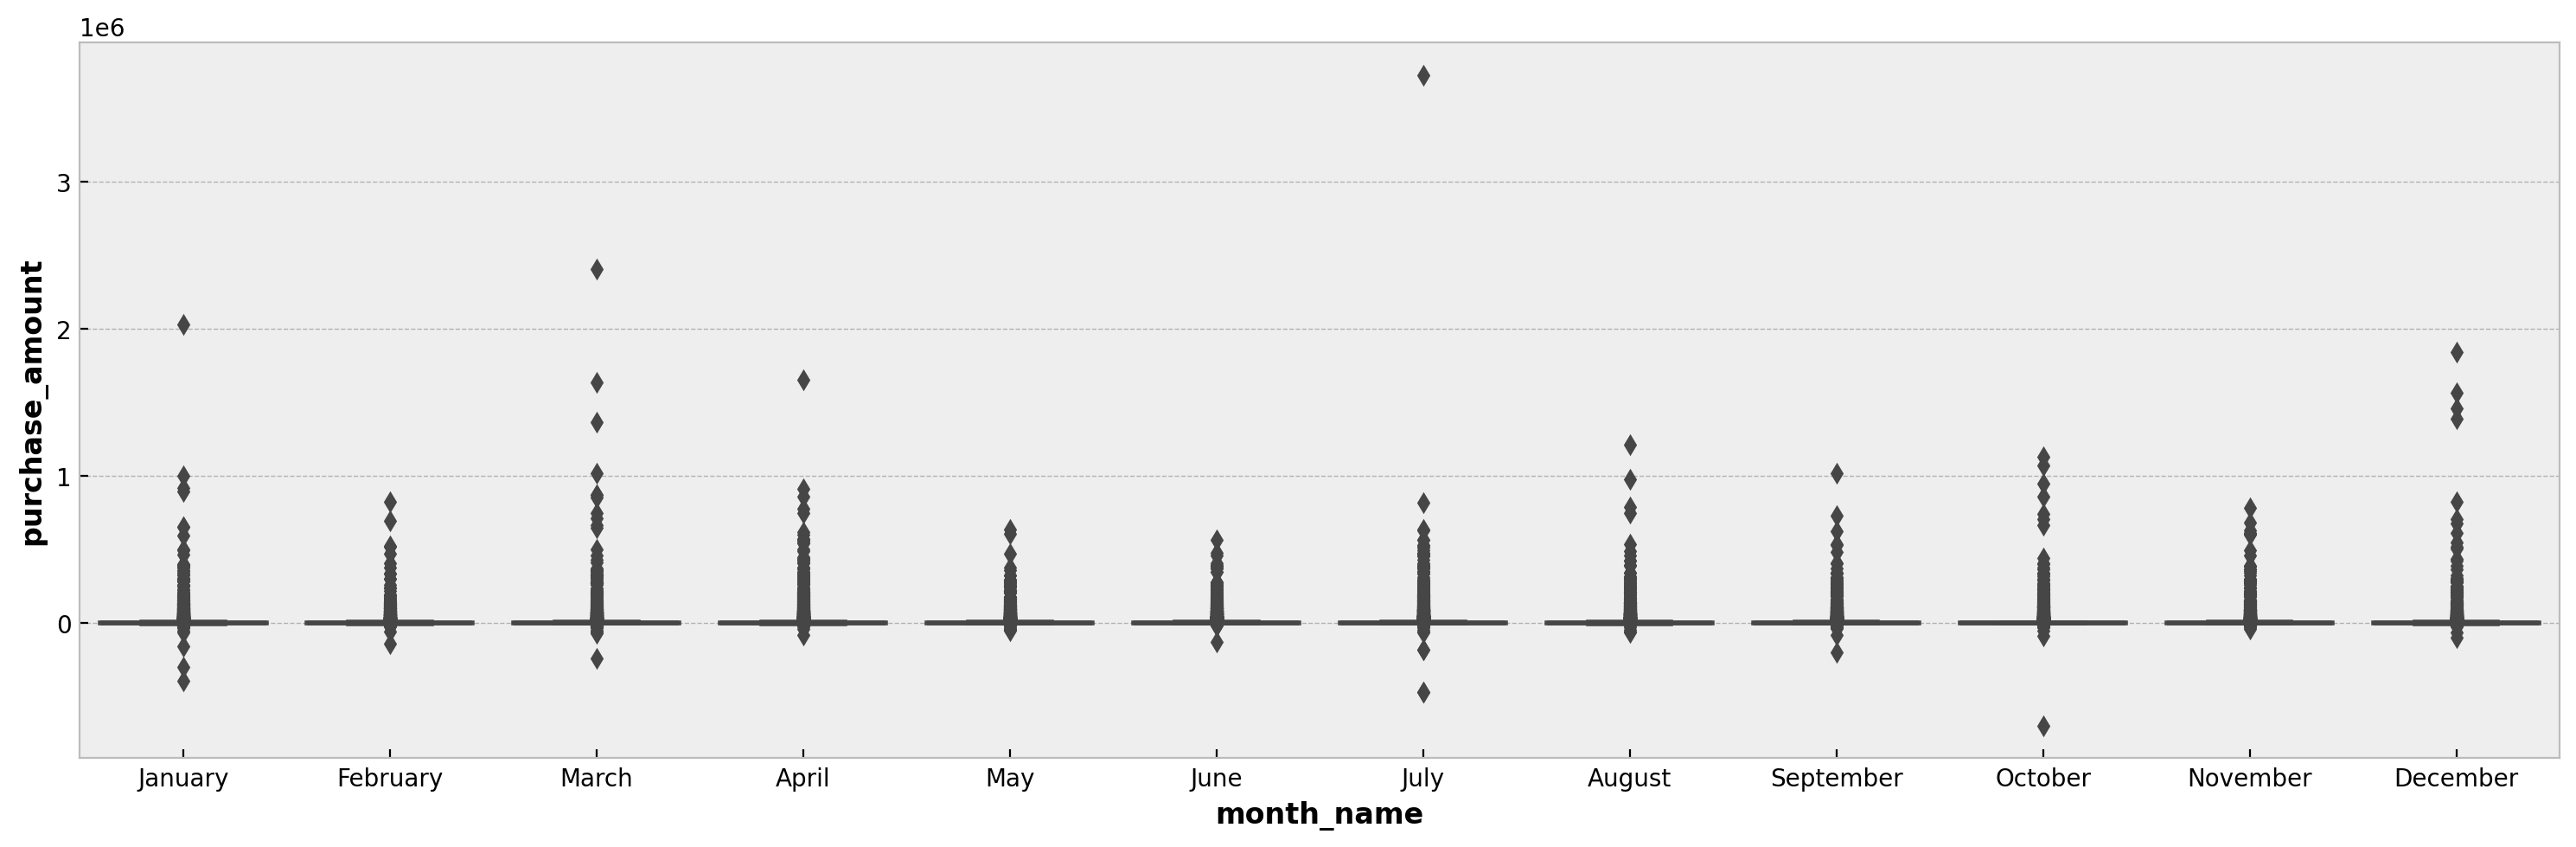

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x = 'month_name', y = 'purchase_amount')

<AxesSubplot:xlabel='year', ylabel='purchase_amount'>

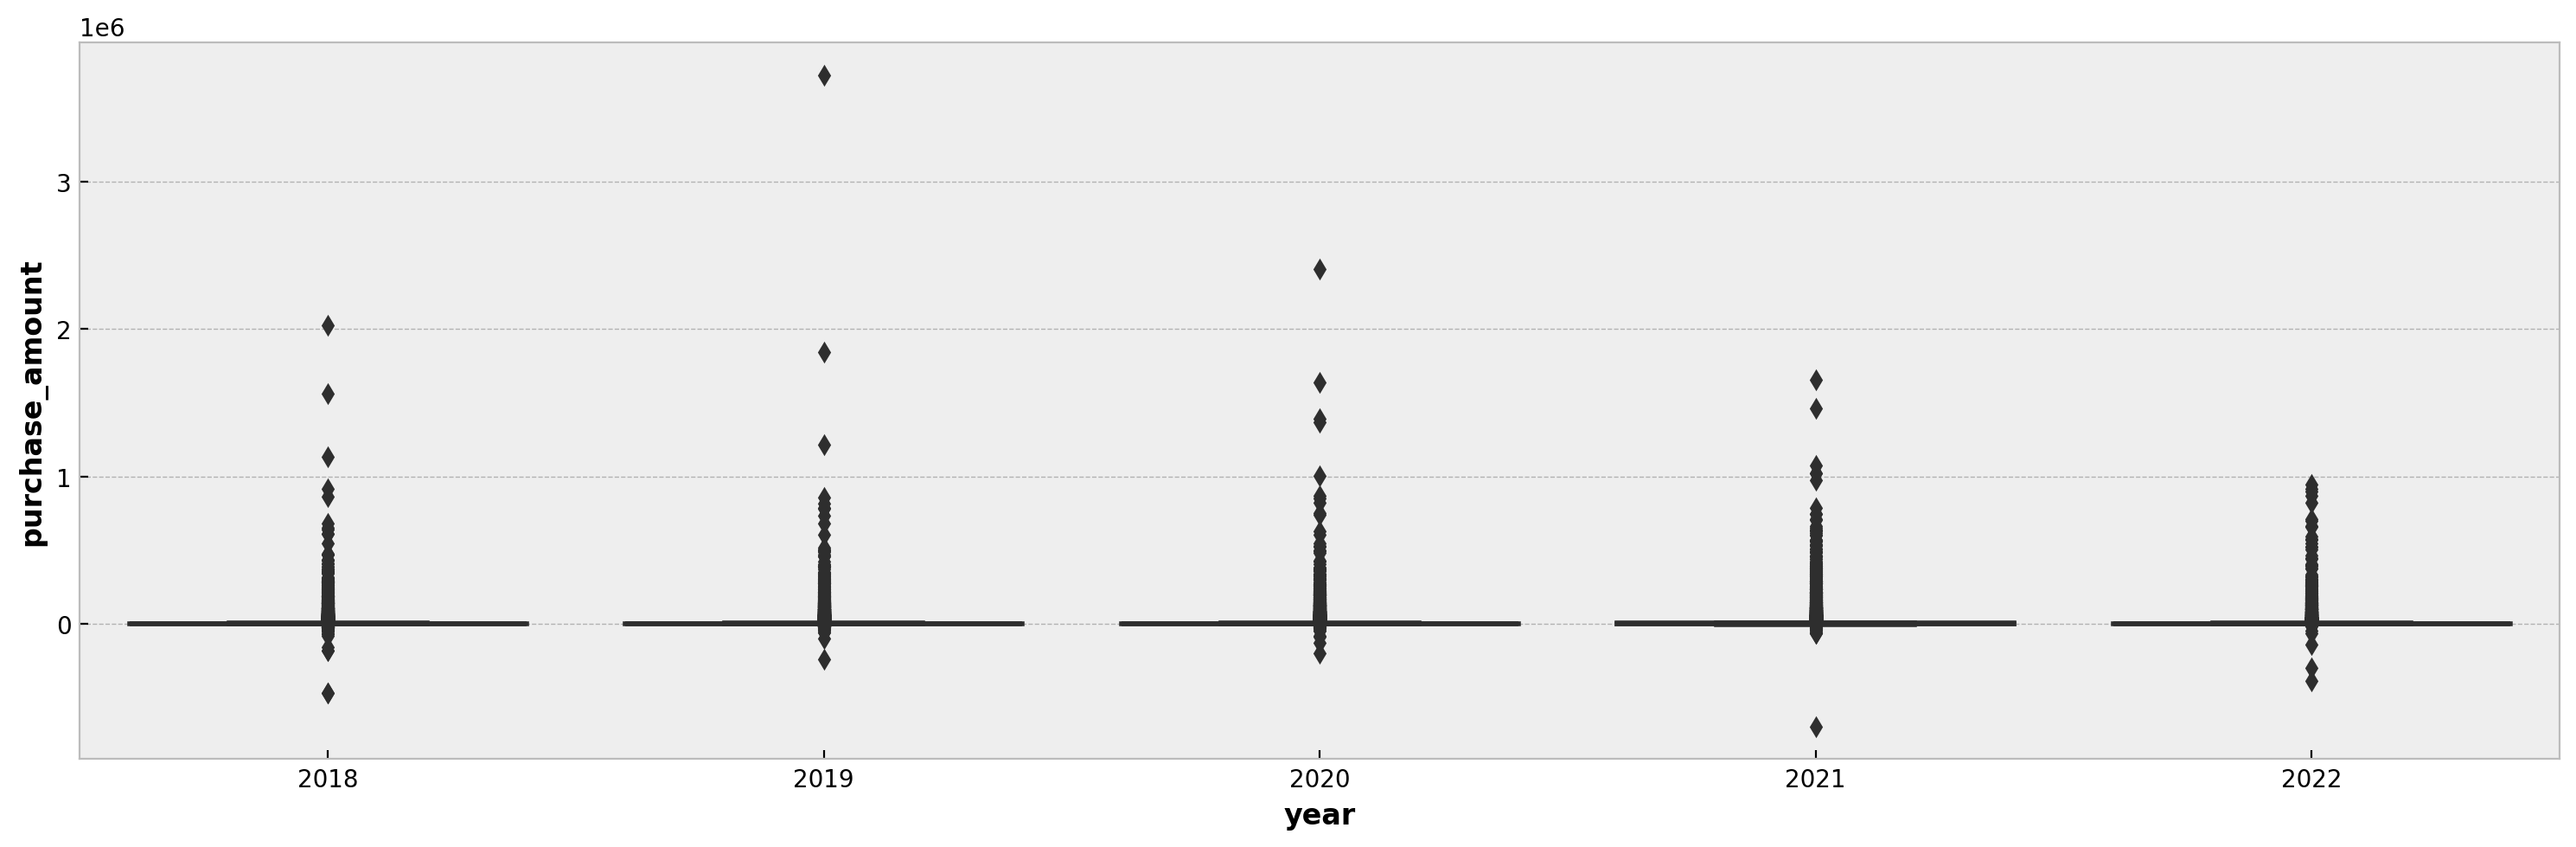

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df, x = 'year', y = 'purchase_amount')

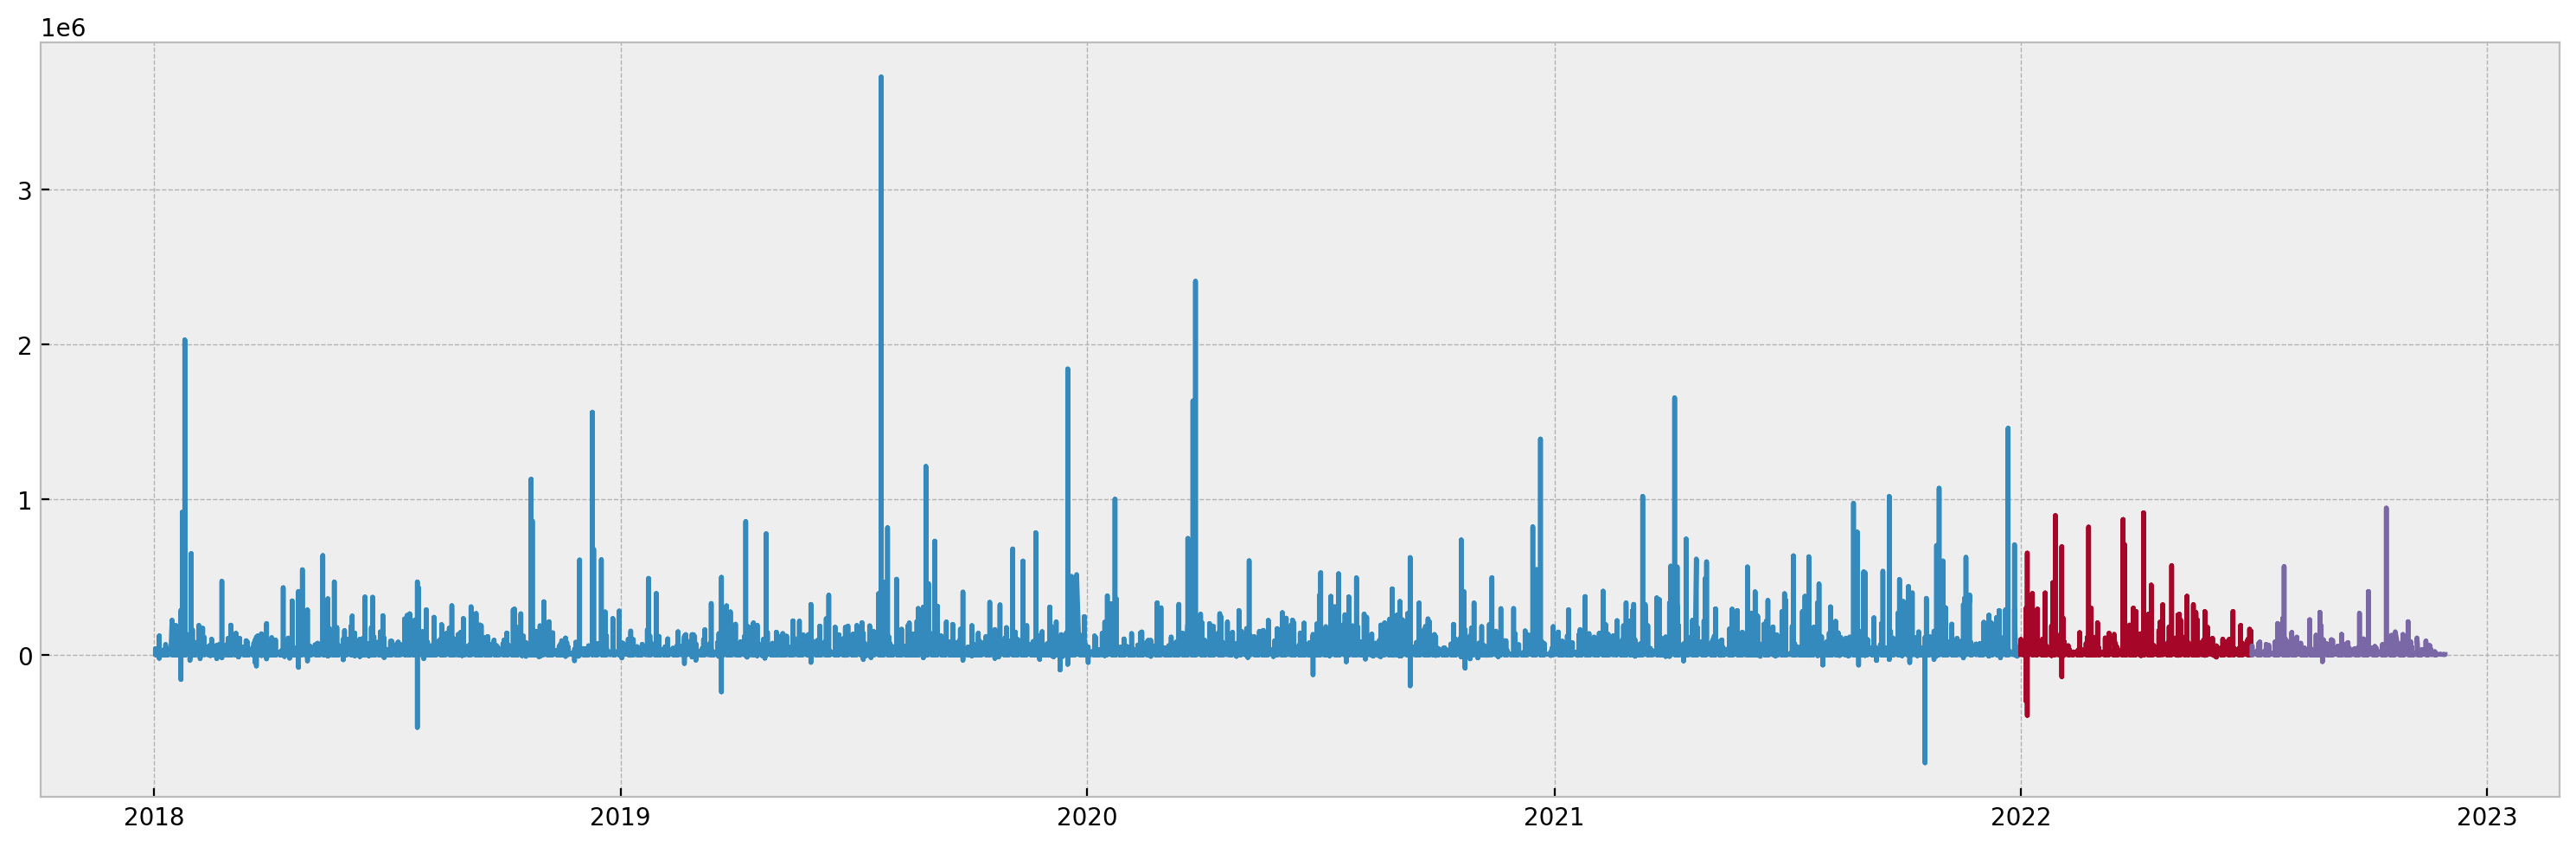

In [10]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(train.index, train['purchase_amount'])
plt.plot(validate.index, validate['purchase_amount'])
plt.plot(test.index, test['purchase_amount'])

### alternative plots

In [19]:
def clean_df(df):
    df = df.drop(columns = ['shipped_date', 'order_date_copy'])
    df['purchase_amount'] = df['purchase_amount'].astype('int64')
    df['customer_zip'] = df['customer_zip'].astype('int16')
    df['order_quantity'] = df['order_quantity'].astype('int16')
    df['unit_price'] = df['unit_price'].astype('float64')
    
    return df

In [20]:
df = clean_df(df)

In [ ]:
df_large_price = df[df['unit_price'] > 5]
df_small_price = df[df['unit_price'] <= 5]

In [ ]:
df_large_price.shape[0], df_small_price.shape[0], df_large_price.shape[0] + df_small_price.shape[0], df.shape[0]

(232629, 29257, 261886, 261886)

In [43]:
df = wr.get_clean_data(start2018=True)
df = clean_df(df)
n = 5
df_large_price = df[df['unit_price'] > n]
df_small_price = df[df['unit_price'] <= n]

lp_train, lp_test = wr.split_data(df_large_price, explore=True)
lp_validate = lp_test.loc[:'2022-06'].copy() 
lp_test = lp_test.loc['2022-07':]

sp_train, sp_test = wr.split_data(df_small_price, explore=True)
sp_validate = sp_test.loc[:'2022-06'].copy() 
sp_test = sp_test.loc['2022-07':]

/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:128: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = df.index.week
/Users/CryanRedrose/codeup-data-science/CodeUp/cisco-time-series-analysis/rosenberger/src/wrangle.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.customer_type.replace({'Assistance Org':'Other'},inplace=True)


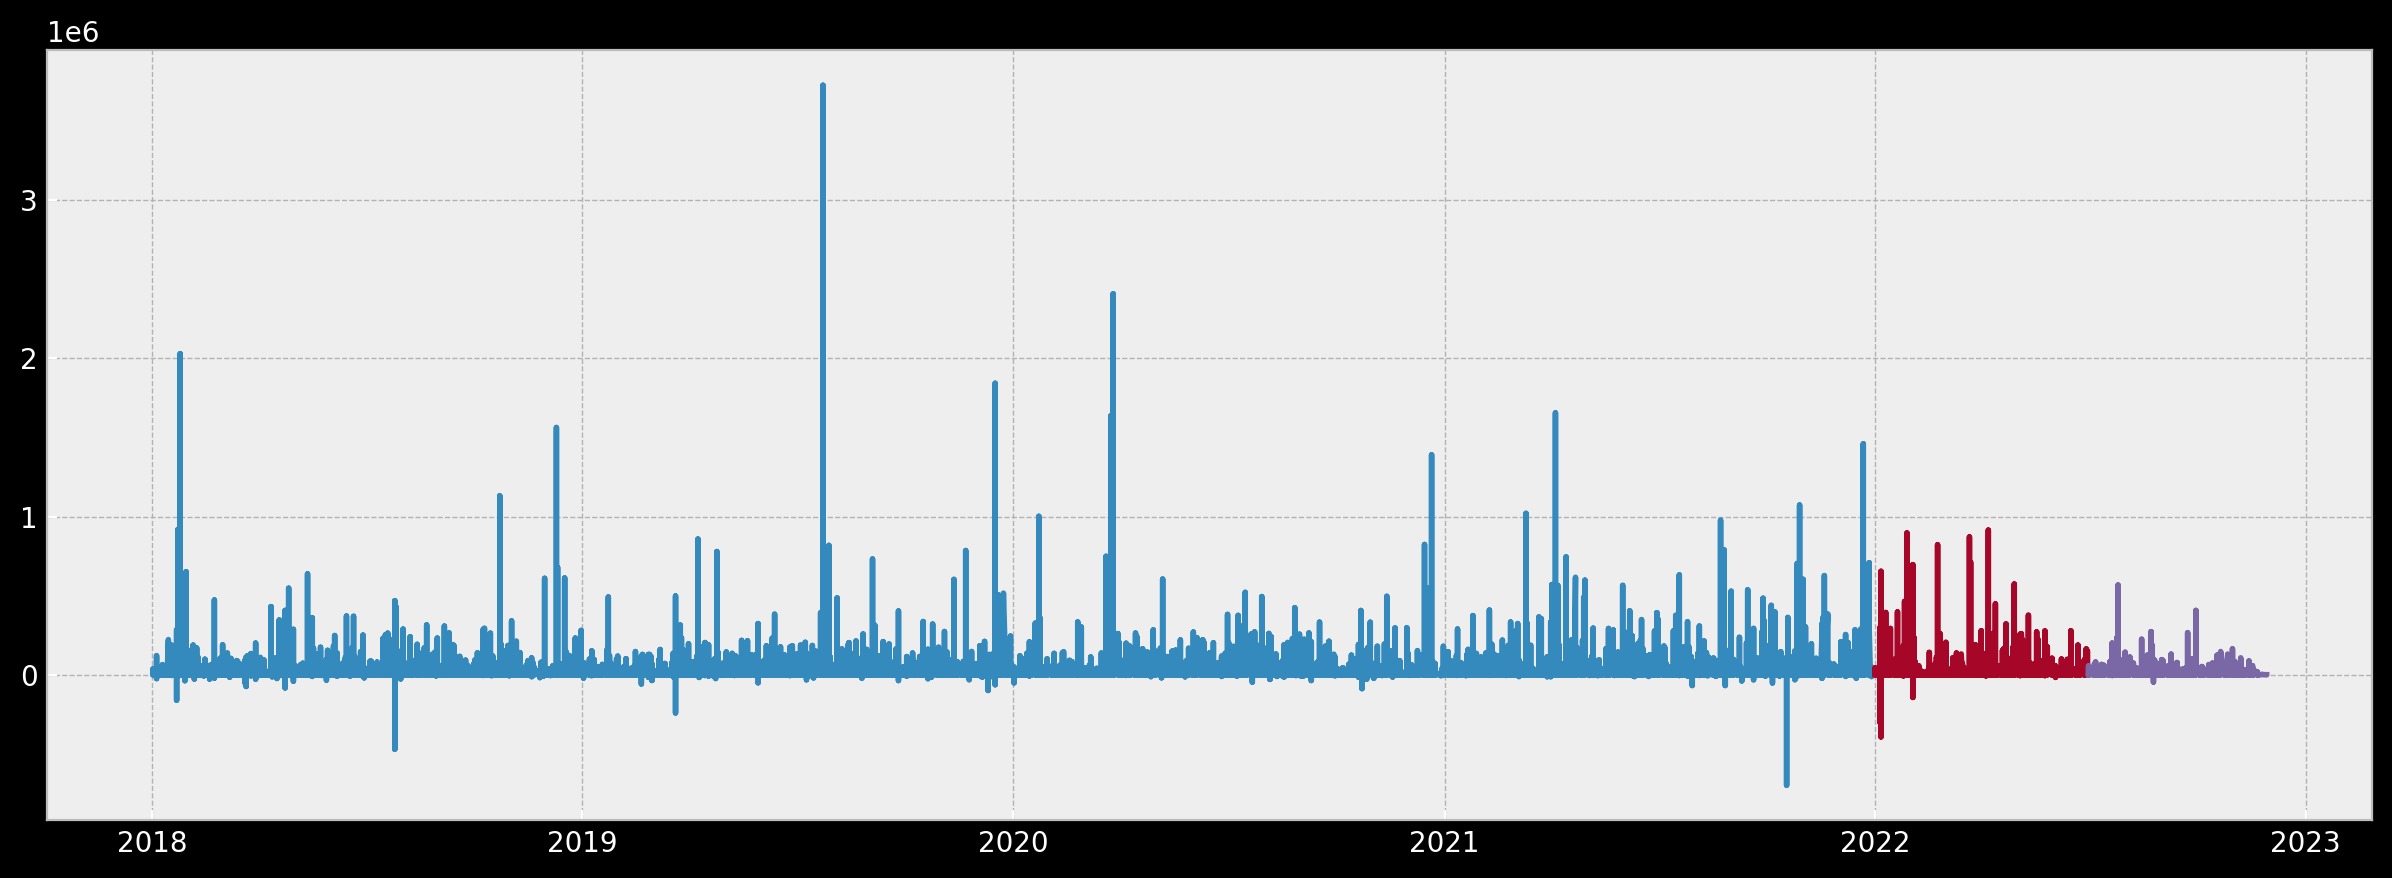

In [44]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(lp_train.index, lp_train['purchase_amount'])
plt.plot(lp_validate.index, lp_validate['purchase_amount'])
plt.plot(lp_test.index, lp_test['purchase_amount'])

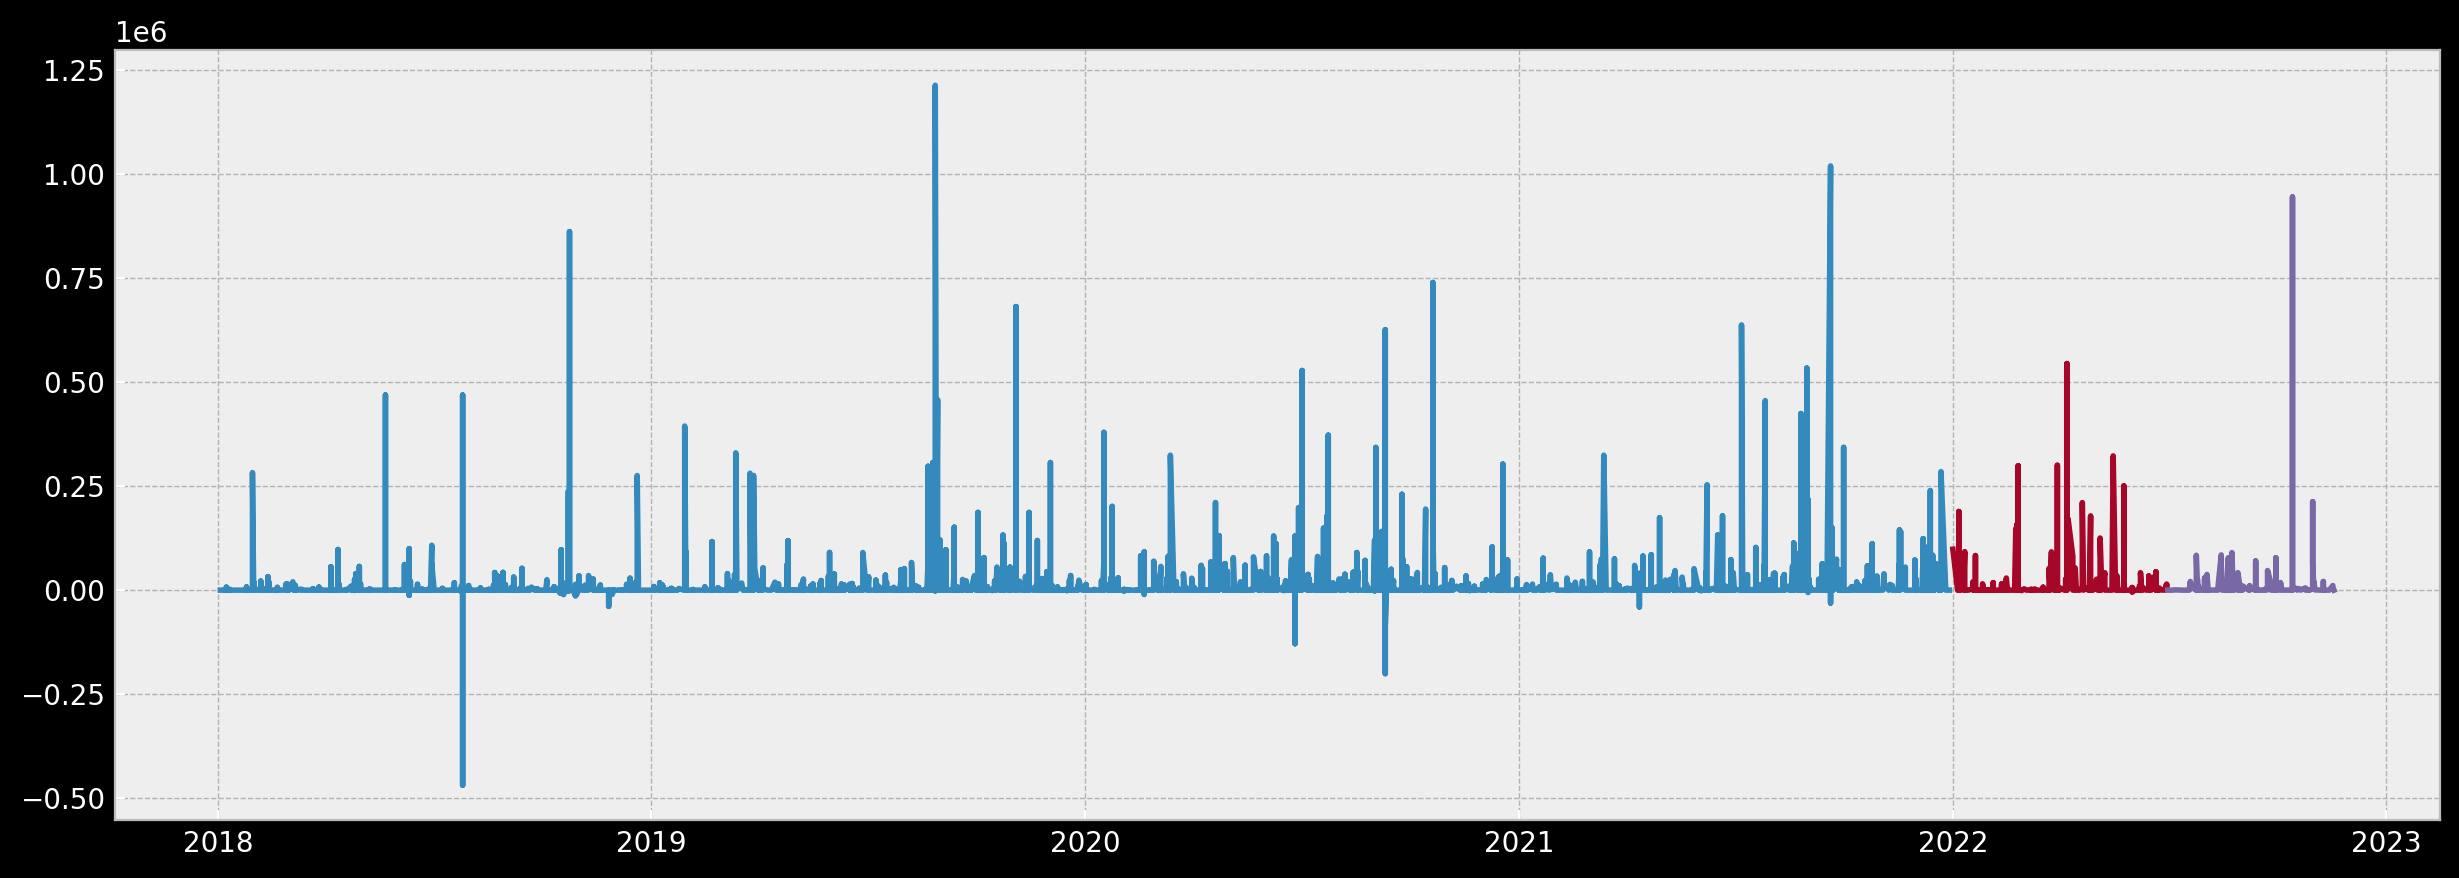

In [45]:
fix, ax = plt.subplots(figsize = (15,5))
plt.plot(sp_train.index, sp_train['purchase_amount'])
plt.plot(sp_validate.index, sp_validate['purchase_amount'])
plt.plot(sp_test.index, sp_test['purchase_amount'])

## Small Train

-[return to TOC](#Table-of-Contents)

<AxesSubplot:xlabel='order_date'>

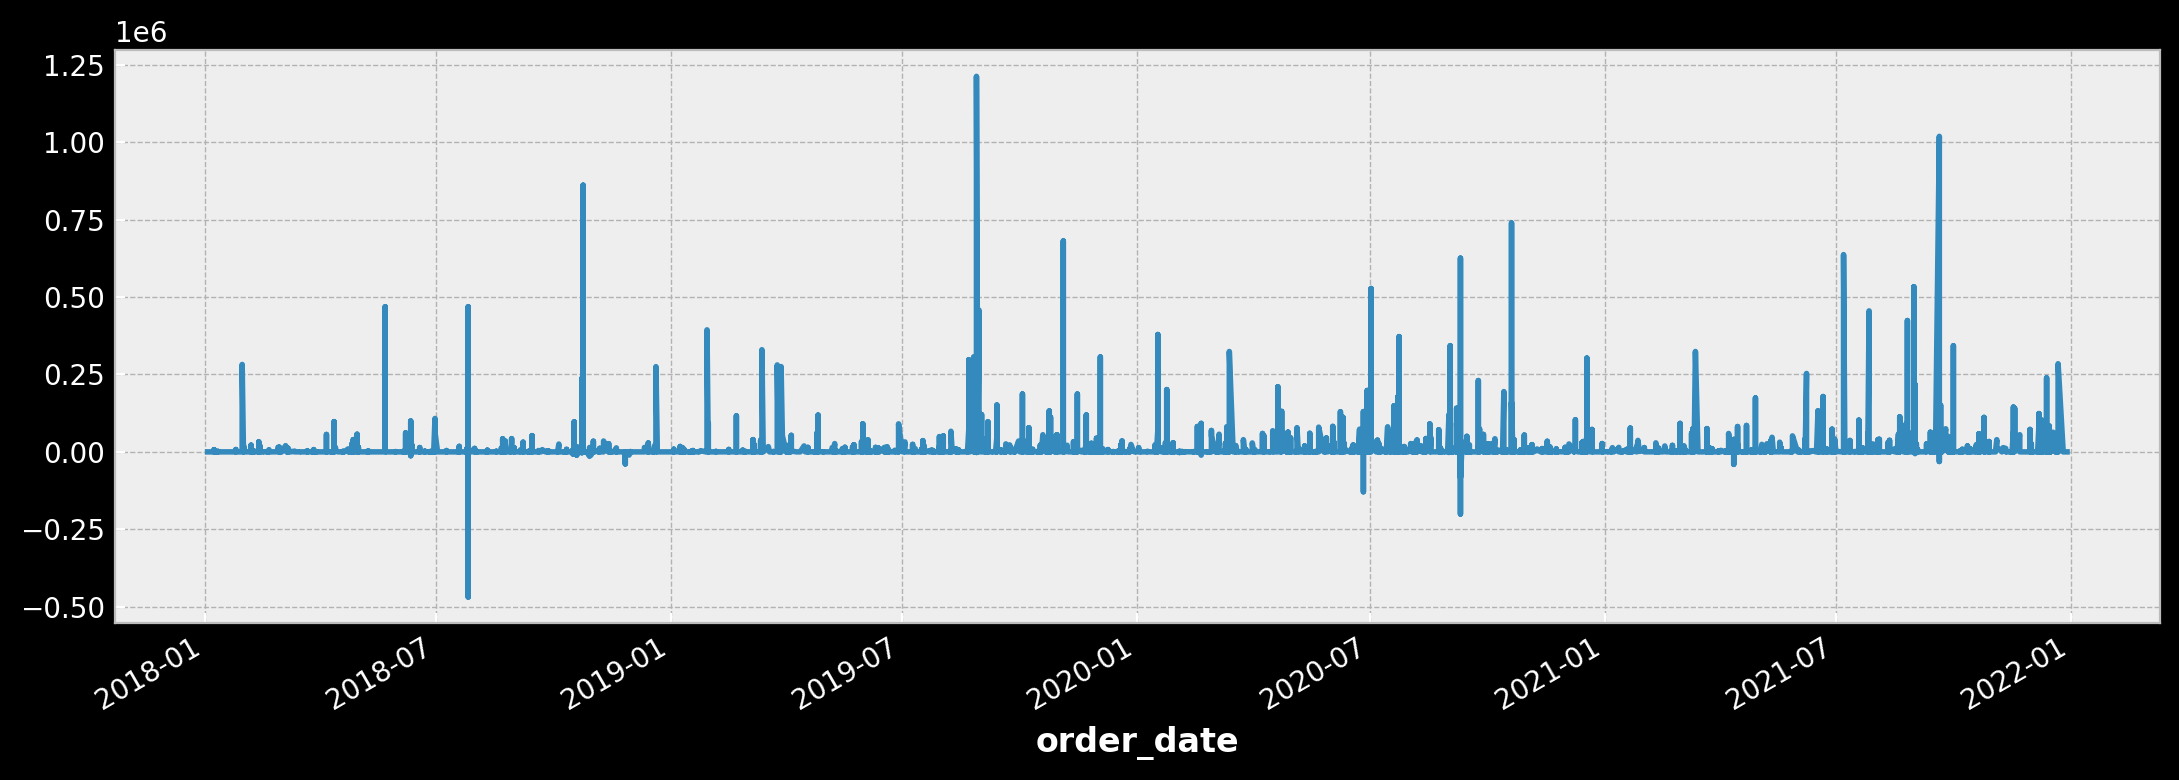

In [53]:
small_train = sp_train['purchase_amount'].copy()
small_train.plot()

In [54]:
small_baseline = small_train.mean()
small_baseline

1797.7566462920686

### Variables
- sp_train
- sp_validate
- sp_test

## Large Train

-[return to TOC](#Table-of-Contents)

<AxesSubplot:xlabel='order_date'>

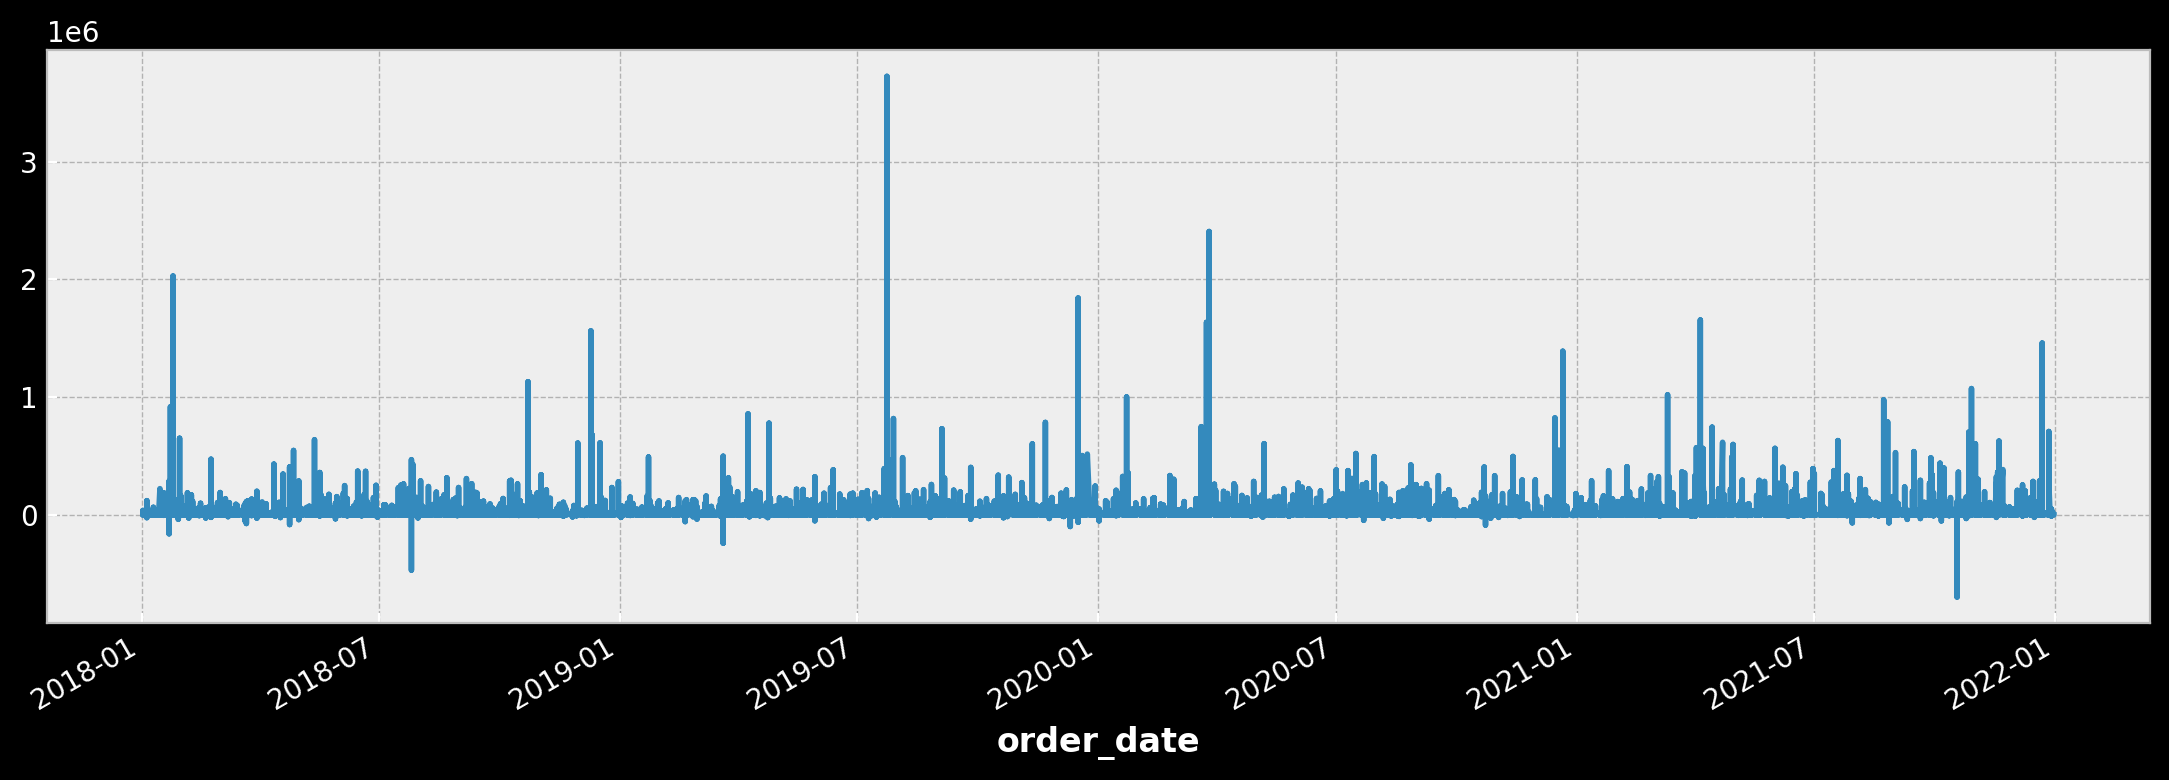

In [55]:
large_train = lp_train['purchase_amount'].copy()
large_train.plot()

In [56]:
large_baseline = large_train.mean()
large_baseline

4353.641042007612

## XGBoost Model standard dataset

-[return to TOC](#Table-of-Contents)

## XGBoost 

In [214]:
df = wr.get_clean_data(start2018=True)
train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

features = ['month', 'week', 'day_of_week', 'year','day_of_year']
target = 'purchase_amount'
x_train = train[features]
y_train = train[target]
x_validate = validate[features]
y_validate = validate[target]

In [215]:
xgboost_regular_model = xgb.XGBRegressor(n_estimators = 1000, 
                         early_stopping_rounds = 50,
                         learning_rate=0.01)
xgboost_regular_model.fit(x_train, y_train,
         eval_set = [(x_train, y_train), (x_validate, y_validate)],
         verbose = 10)
                         

[0]	validation_0-rmse:24440.07549	validation_1-rmse:28822.71383
[10]	validation_0-rmse:24360.91935	validation_1-rmse:28738.25694
[20]	validation_0-rmse:24294.89238	validation_1-rmse:28669.79208
[30]	validation_0-rmse:24239.68707	validation_1-rmse:28612.51180
[40]	validation_0-rmse:24192.92933	validation_1-rmse:28564.39487
[50]	validation_0-rmse:24153.75170	validation_1-rmse:28524.41218
[60]	validation_0-rmse:24121.07320	validation_1-rmse:28490.52209
[70]	validation_0-rmse:24093.28484	validation_1-rmse:28463.91321
[80]	validation_0-rmse:24070.07107	validation_1-rmse:28441.63222
[90]	validation_0-rmse:24050.27331	validation_1-rmse:28424.13923
[100]	validation_0-rmse:24033.25716	validation_1-rmse:28409.66610
[110]	validation_0-rmse:24016.09242	validation_1-rmse:28398.19810
[120]	validation_0-rmse:23998.36585	validation_1-rmse:28389.64829
[130]	validation_0-rmse:23982.62792	validation_1-rmse:28382.98242
[140]	validation_0-rmse:23969.02136	validation_1-rmse:28379.15454
[150]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

### XGBoost Feature importance

In [54]:
xgboost_features = pd.DataFrame(data=model.feature_importances_,
                                 index=model.feature_names_in_,
                                 columns=['importance'])

In [51]:
xgboost_features.sort_values('importance')

,importance
quarter,0.00000
day_of_week,0.15439
week,0.15519
month,0.17037
year,0.20094
day_of_year,0.31911


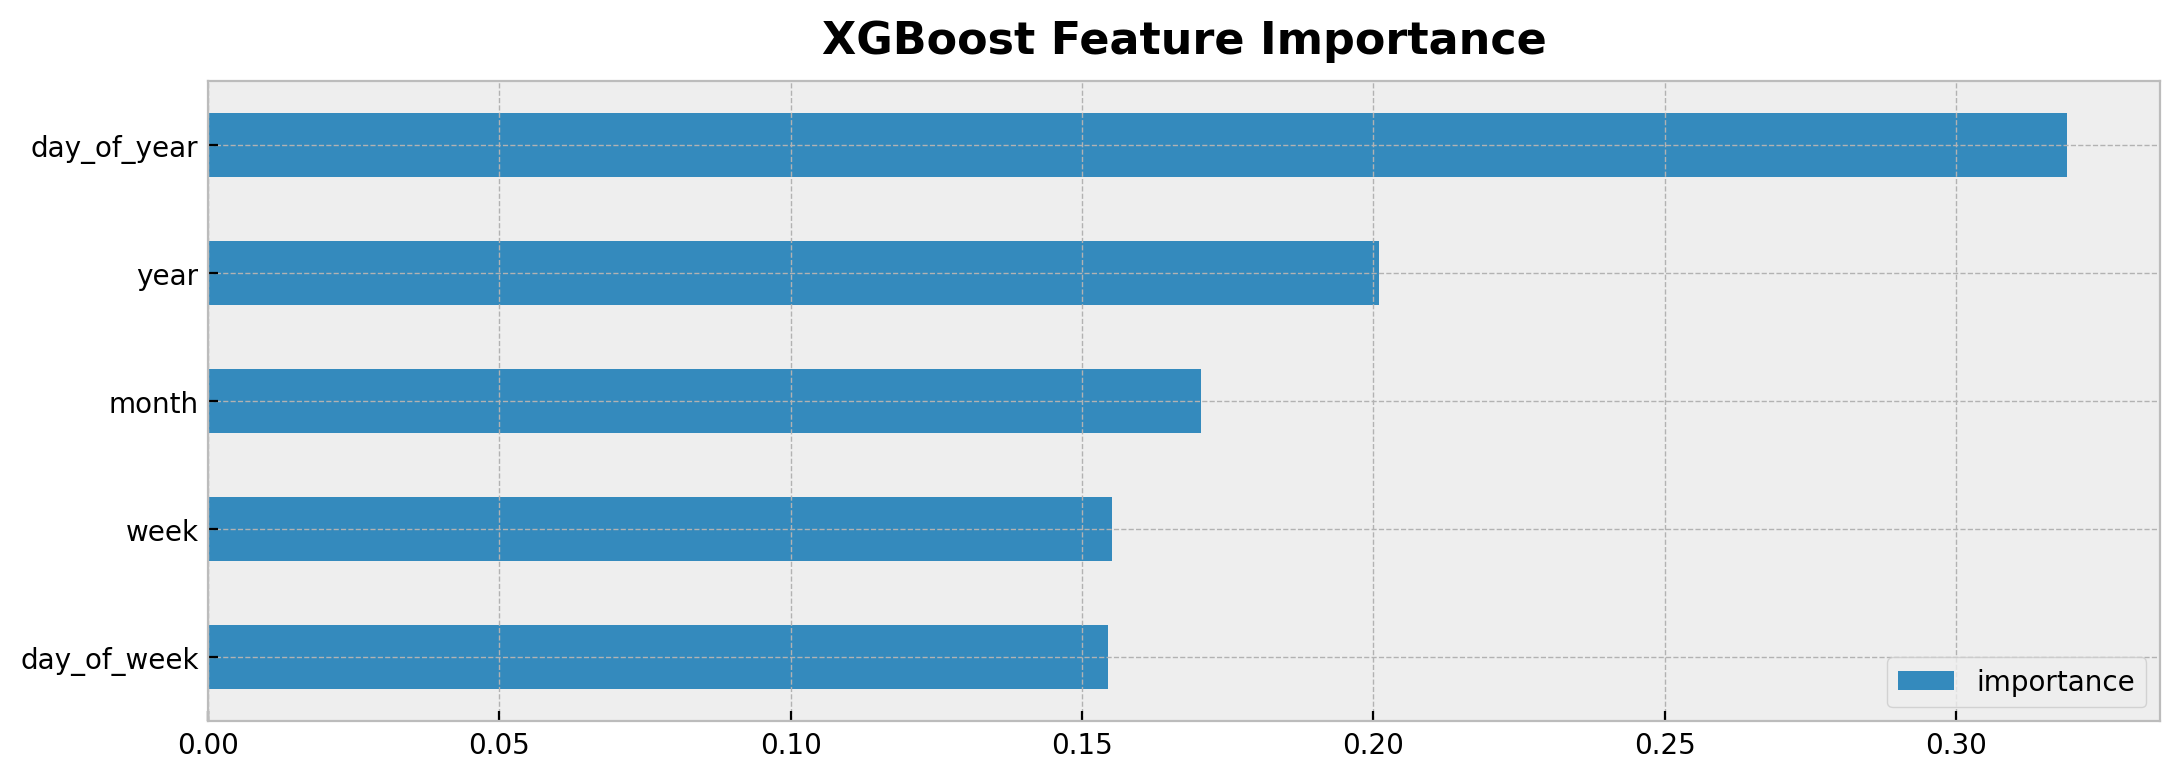

In [56]:
xgboost_features.sort_values('importance').plot(kind='barh', title = 'XGBoost Feature Importance')
plt.show()

## Validating XGBoost Model

In [216]:
xgboost_regular_model.predict(x_validate)

array([3644.9868, 3644.9868, 3644.9868, ..., 4658.1455, 4658.1455,
       4658.1455], dtype=float32)

In [217]:
validate['predicted_purchases'] = xgboost_regular_model.predict(x_validate)
val_df = df.merge(validate[['predicted_purchases']], how='left', left_index=True, right_index=True)

In [218]:
validate.sort_values(by ='predicted_purchases', ascending = False).head()

,customer_name,customer_type,customer_city,reseller_name,reseller_city,customer_zip,order_quantity,unit_price,po_number,shipped_date,...,year,quarter,month_name,day_name,month,week,day_of_week,day_of_year,purchase_amount,predicted_purchases
order_date,,,,,,,,,,,,,,,,,,,,,
2022-04-02,Lyford Consolidated Independent School District,K-12,Lyford,"Insight Public Sector, Inc.",Tempe,"78,569.00",120.00,18.41,130196,2022-06-30,...,2022,2,April,Saturday,4,13,5,92,"2,209.20","12,972.62"
2022-03-11,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Netsync Network Solutions, Inc.",Houston,78586,2.00,246.09,8732200181,2022-04-04,...,2022,1,March,Friday,3,10,4,70,492.18,"9,187.15"
2022-03-11,DeWitt County,Local Government,Cuero,"SHI Government Solutions, Inc.",Austin,77954,1.00,142.71,PO05683,2022-03-17,...,2022,1,March,Friday,3,10,4,70,142.71,"9,187.15"
2022-03-11,Texas Department of State Health Services,State Agency,Austin,"Insight Public Sector, Inc.",Tempe,78756,"3,783.57",0.79,HHSTX-2-283310,2022-03-16,...,2022,1,March,Friday,3,10,4,70,"2,989.02","9,187.15"
2022-03-11,San Benito Consolidated Independent School Dis...,K-12,San Benito,"Netsync Network Solutions, Inc.",Houston,78586,6.00,"7,097.30",8732200181,2022-04-24,...,2022,1,March,Friday,3,10,4,70,"42,583.80","9,187.15"


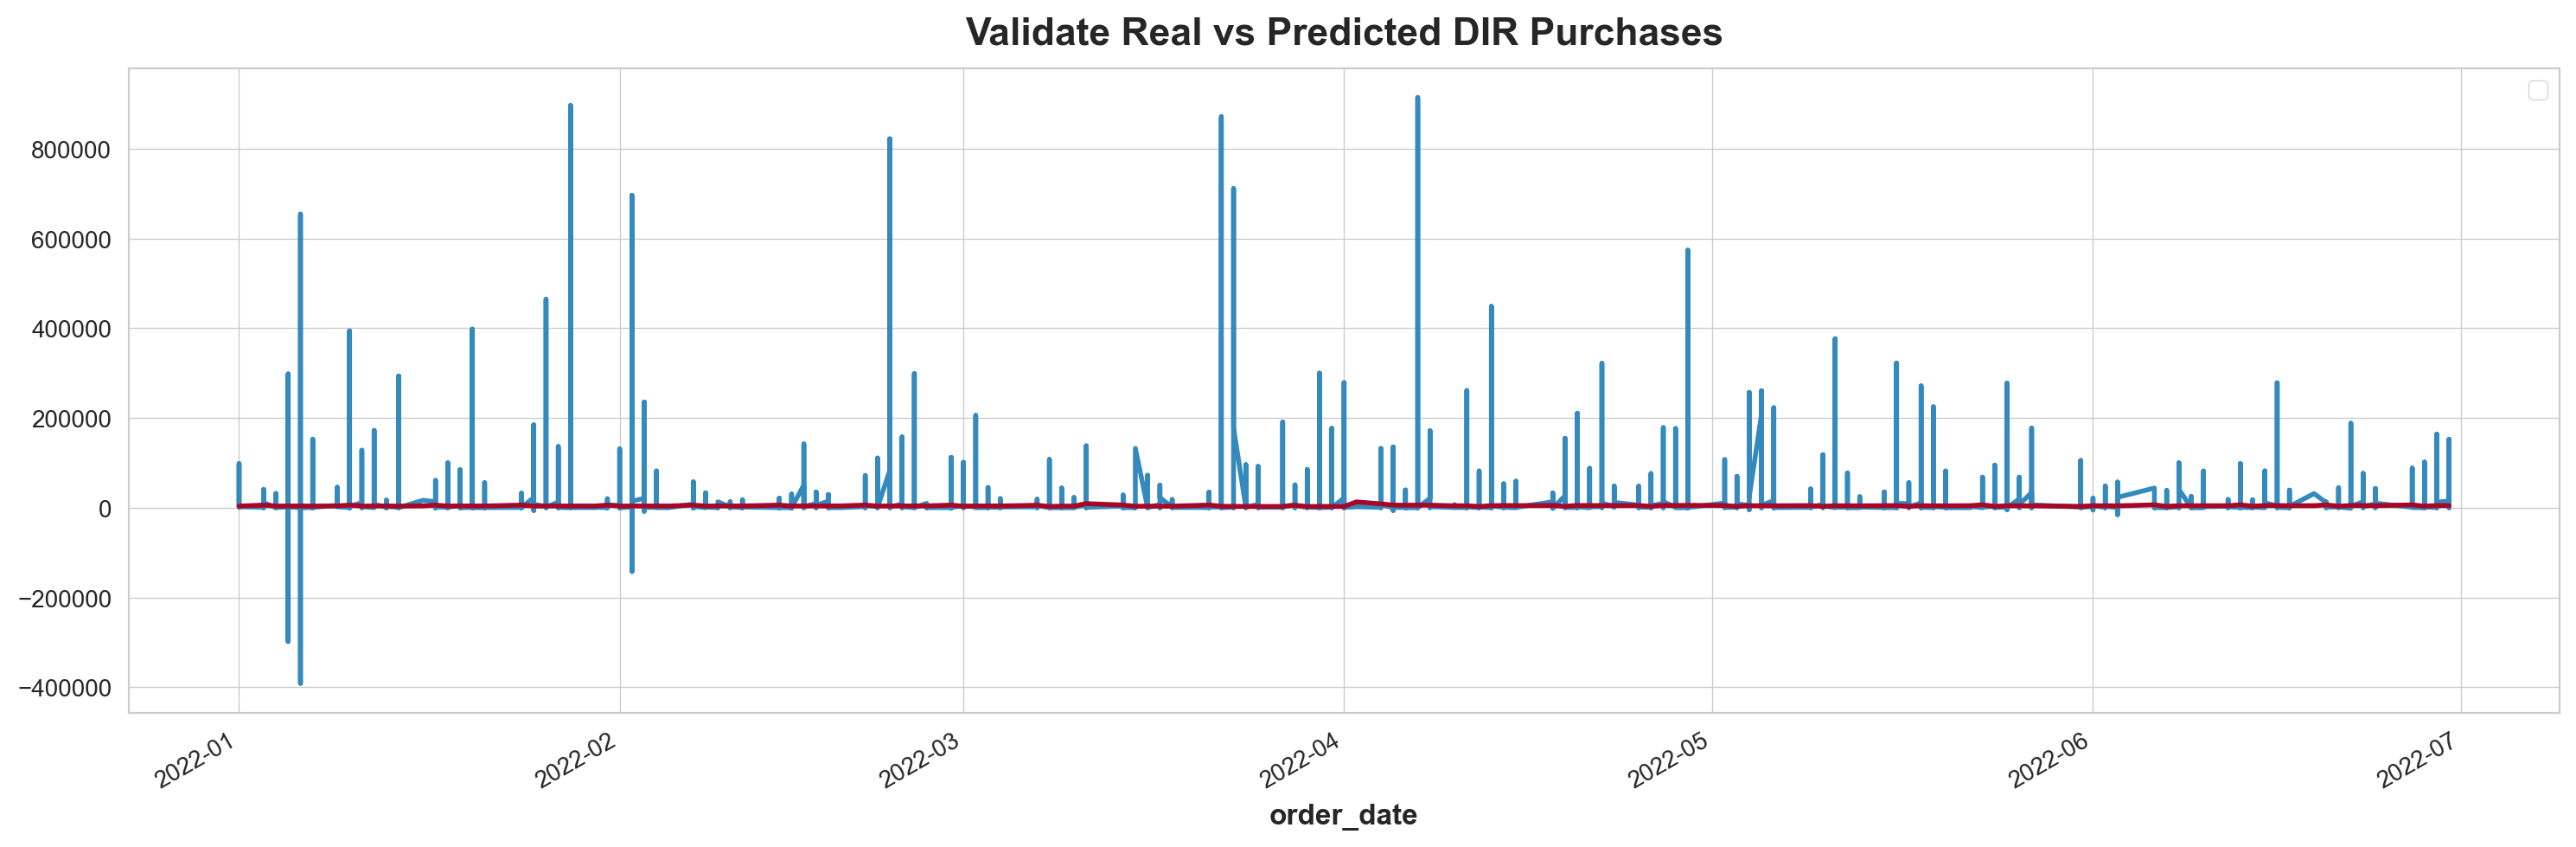

In [219]:
ax = validate['purchase_amount'].plot(figsize=(15,5))
validate['predicted_purchases'].plot(ax=ax)
ax.set_title('Validate Real vs Predicted DIR Purchases')
plt.legend('Real Purchases', 'Predicted Purchases')
plt.show()

## XGBoost Model summary dataset

-[return to TOC](#Table-of-Contents)

In [220]:
df = su.get_summary_df(wr.get_clean_data(start2018=True))
df = wr.add_date_features(df)

train, test = wr.split_data(df, explore=True)
validate = test.loc[:'2022-06'].copy() 
test = test.loc['2022-07':]

features = ['month', 'week', 'day_of_week', 'year','day_of_year']
target = 'purchase_amount'
x_train_sum = train[features]
y_train_sum = train[target]
x_validate_sum = validate[features]
y_validate_sum = validate[target]

In [221]:
xgboost_summary_model = xgb.XGBRegressor(n_estimators = 1000, 
                         early_stopping_rounds = 50,
                         learning_rate=0.01)
xgboost_summary_model.fit(x_train_sum, y_train_sum,
         eval_set = [(x_train_sum, y_train_sum), (x_validate_sum, y_validate_sum)],
         verbose = 10)

[0]	validation_0-rmse:129605.66336	validation_1-rmse:120782.60288
[10]	validation_0-rmse:128762.34833	validation_1-rmse:119911.48951
[20]	validation_0-rmse:128057.37237	validation_1-rmse:119208.15047
[30]	validation_0-rmse:127462.77339	validation_1-rmse:118625.50137
[40]	validation_0-rmse:126960.26755	validation_1-rmse:118171.79533
[50]	validation_0-rmse:126541.28030	validation_1-rmse:117791.59524
[60]	validation_0-rmse:126188.39961	validation_1-rmse:117469.94346
[70]	validation_0-rmse:125892.50329	validation_1-rmse:117212.05815
[80]	validation_0-rmse:125636.97296	validation_1-rmse:117024.26255
[90]	validation_0-rmse:125422.41844	validation_1-rmse:116874.01776
[100]	validation_0-rmse:125240.40653	validation_1-rmse:116752.98215
[110]	validation_0-rmse:125080.01431	validation_1-rmse:116659.62161
[120]	validation_0-rmse:124949.30837	validation_1-rmse:116591.39559
[130]	validation_0-rmse:124826.80715	validation_1-rmse:116530.63053
[140]	validation_0-rmse:124712.75733	validation_1-rmse:1164

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Model Evaluation

-[return to TOC](#Table-of-Contents)

## Setting up an evaluation holding dataframe

In [222]:
baseline_a = y_train.copy().resample('D').sum()
baseline_b = y_train.copy().resample('W').sum()
baseline_c = y_train.copy().resample('M').sum()
baseline_d = y_train.mean()
baseline_e = y_train_sum.copy().resample('D').sum()
baseline_f = y_train_sum.copy().resample('W').sum()
baseline_g = y_train_sum.copy().resample('M').sum()
baseline_h = y_train_sum.mean()


baseline_a_estimate = baseline_a.mean()
baseline_b_estimate = baseline_b.mean()
baseline_c_estimate = baseline_c.mean()
baseline_d_estimate = baseline_d
baseline_e_estimate = baseline_e.mean()
baseline_f_estimate = baseline_f.mean()
baseline_g_estimate = baseline_g.mean()
baseline_h_estimate = baseline_h

In [223]:
baseline_a_estimate, baseline_b_estimate, baseline_c_estimate, baseline_d_estimate, baseline_e_estimate, baseline_f_estimate, baseline_g_estimate, baseline_h_estimate

(654835.7355890411,
 4574450.593110048,
 19917920.290833335,
 4059.2725781135823,
 654835.7355890411,
 4574450.593110048,
 19917920.290833335,
 31568.769158329145)

In [224]:
baseline_train_estimate_a = np.full((y_train.shape), baseline_a_estimate)
baseline_train_validate_a = np.full((y_validate.shape), baseline_a_estimate)
baseline_train_estimate_b = np.full((y_train.shape), baseline_b_estimate)
baseline_train_validate_b = np.full((y_validate.shape), baseline_b_estimate)
baseline_train_estimate_c = np.full((y_train.shape), baseline_c_estimate)
baseline_train_validate_c = np.full((y_validate.shape), baseline_c_estimate)
baseline_train_estimate_d = np.full((y_train.shape), baseline_d_estimate)
baseline_train_validate_d = np.full((y_validate.shape), baseline_d_estimate)

In [225]:

'''
# evaluating models using R^2
baselineR2train         = r2_score(y_train, baseline_train_estimate)
baselineR2validate      = r2_score(y_validate, baseline_train_validate)
xgb_regular_R2_train    = r2_score(y_train, xgboost_regular_model.predict(x_train))
xgb_regular_R2_validate = r2_score(y_validate, xgboost_regular_model.predict(x_validate))
xgb_summary_R2_train    = r2_score(y_train, xgboost_summary_model.predict(x_train))
xgb_summary_R2_validate = r2_score(y_validate, xgboost_summary_model.predict(x_validate))
'''


# evaluating models using RMSE

baselineRMSEtrain_a         = mean_squared_error(y_train, baseline_train_estimate_a, squared = False)
baselineRMSEvalidate_a      = mean_squared_error(y_validate, baseline_train_validate_a, squared = False)
baselineRMSEtrain_b         = mean_squared_error(y_train, baseline_train_estimate_b, squared = False)
baselineRMSEvalidate_b      = mean_squared_error(y_validate, baseline_train_validate_b, squared = False)
baselineRMSEtrain_c         = mean_squared_error(y_train, baseline_train_estimate_c, squared = False)
baselineRMSEvalidate_c      = mean_squared_error(y_validate, baseline_train_validate_c, squared = False)
baselineRMSEtrain_d         = mean_squared_error(y_train, baseline_train_estimate_d, squared = False)
baselineRMSEvalidate_d      = mean_squared_error(y_validate, baseline_train_validate_d, squared = False)
xgb_regular_RMSE_train    = mean_squared_error(y_train, xgboost_regular_model.predict(x_train), squared = False)
xgb_regular_RMSE_validate = mean_squared_error(y_validate, xgboost_regular_model.predict(x_validate), squared = False)
xgb_summary_RMSE_train    = mean_squared_error(y_train, xgboost_summary_model.predict(x_train), squared = False)
xgb_summary_RMSE_validate = mean_squared_error(y_validate, xgboost_summary_model.predict(x_validate), squared = False)


In [226]:
eval_df = pd.DataFrame(columns=['model_name', 'train_RMSE', 'validate_RMSE'])

eval_df.loc[0] = ['baseline_a', baselineRMSEtrain_a, baselineRMSEvalidate_a]
eval_df.loc[1] = ['baseline_b', baselineRMSEtrain_b, baselineRMSEvalidate_b]
eval_df.loc[2] = ['baseline_c', baselineRMSEtrain_c, baselineRMSEvalidate_c]
eval_df.loc[3] = ['baseline_d', baselineRMSEtrain_d, baselineRMSEvalidate_d]
eval_df.loc[4] = ['xgb_regular', xgb_regular_RMSE_train, xgb_regular_RMSE_validate]
eval_df.loc[5] = ['xgb_summary', xgb_summary_RMSE_train, xgb_summary_RMSE_validate]


In [227]:
eval_df

,model_name,train_RMSE,validate_RMSE
0,baseline_a,"651,222.91","650,140.70"
1,baseline_b,"4,570,454.91","4,569,225.54"
2,baseline_c,"19,913,875.61","19,912,627.52"
3,baseline_d,"24,109.56","28,366.15"
4,xgb_regular,"23,951.06","28,373.56"
5,xgb_summary,"36,061.47","37,059.26"


## These xgboost models will be very close compared to predictive modeling from time based modeling approaches. They work well by doing something close to averaging sales on a daily basis based on previous periods (days of the week, annual, week of the year). Considering that every day, there are very different sales, they beat any kind of model which seeks to find seasonal and or daily values to guess based on trends. 

In [228]:
test_df = pd.DataFrame()

x_test                  = test[features]
y_test                  = test[target]
baseline_d_test         = np.full((y_test.shape), baseline_d)
xgb_regular_RMSE_test   = mean_squared_error(y_test, xgboost_regular_model.predict(x_test), squared = False)

test_df['order_date']                = test_df.index
test_df['actuals']                   = y_test
test_df['baseline_d_predictions']      = np.full((y_test.shape), baseline_d)
test_df['xgboost_regular_model_predictions'] = xgboost_regular_model.predict(x_test)


In [229]:
test_df

,order_date,actuals,baseline_d_predictions,xgboost_regular_model_predictions
order_date,,,,
2022-07-01,NaN,"13,918.00","4,059.27","4,583.40"
2022-07-01,NaN,329.60,"4,059.27","4,583.40"
2022-07-01,NaN,"10,692.95","4,059.27","4,583.40"
2022-07-01,NaN,"61,585.18","4,059.27","4,583.40"
2022-07-01,NaN,552.30,"4,059.27","4,583.40"
...,...,...,...,...
2022-11-25,NaN,"2,469.24","4,059.27","4,194.13"
2022-11-28,NaN,525.78,"4,059.27","4,321.14"
2022-11-28,NaN,430.00,"4,059.27","4,321.14"


In [230]:
baseline_d_test         = np.full((y_test.shape), baseline_d)
baselineRMSE_test_d  = mean_squared_error(y_test, baseline_d_test, squared = False)
xgb_regular_RMSE_test   = mean_squared_error(y_test, xgboost_regular_model.predict(x_test), squared = False)


test_eval = pd.DataFrame(columns=['model_name', 'test_RMSE'])

test_eval.loc[0] = ['baseline_d', baselineRMSE_test_d]
test_eval.loc[1] = ['xgb_regular', xgb_regular_RMSE_test]

In [231]:
test_eval

,model_name,test_RMSE
0,baseline_d,"113,236.77"
1,xgb_regular,"112,955.38"


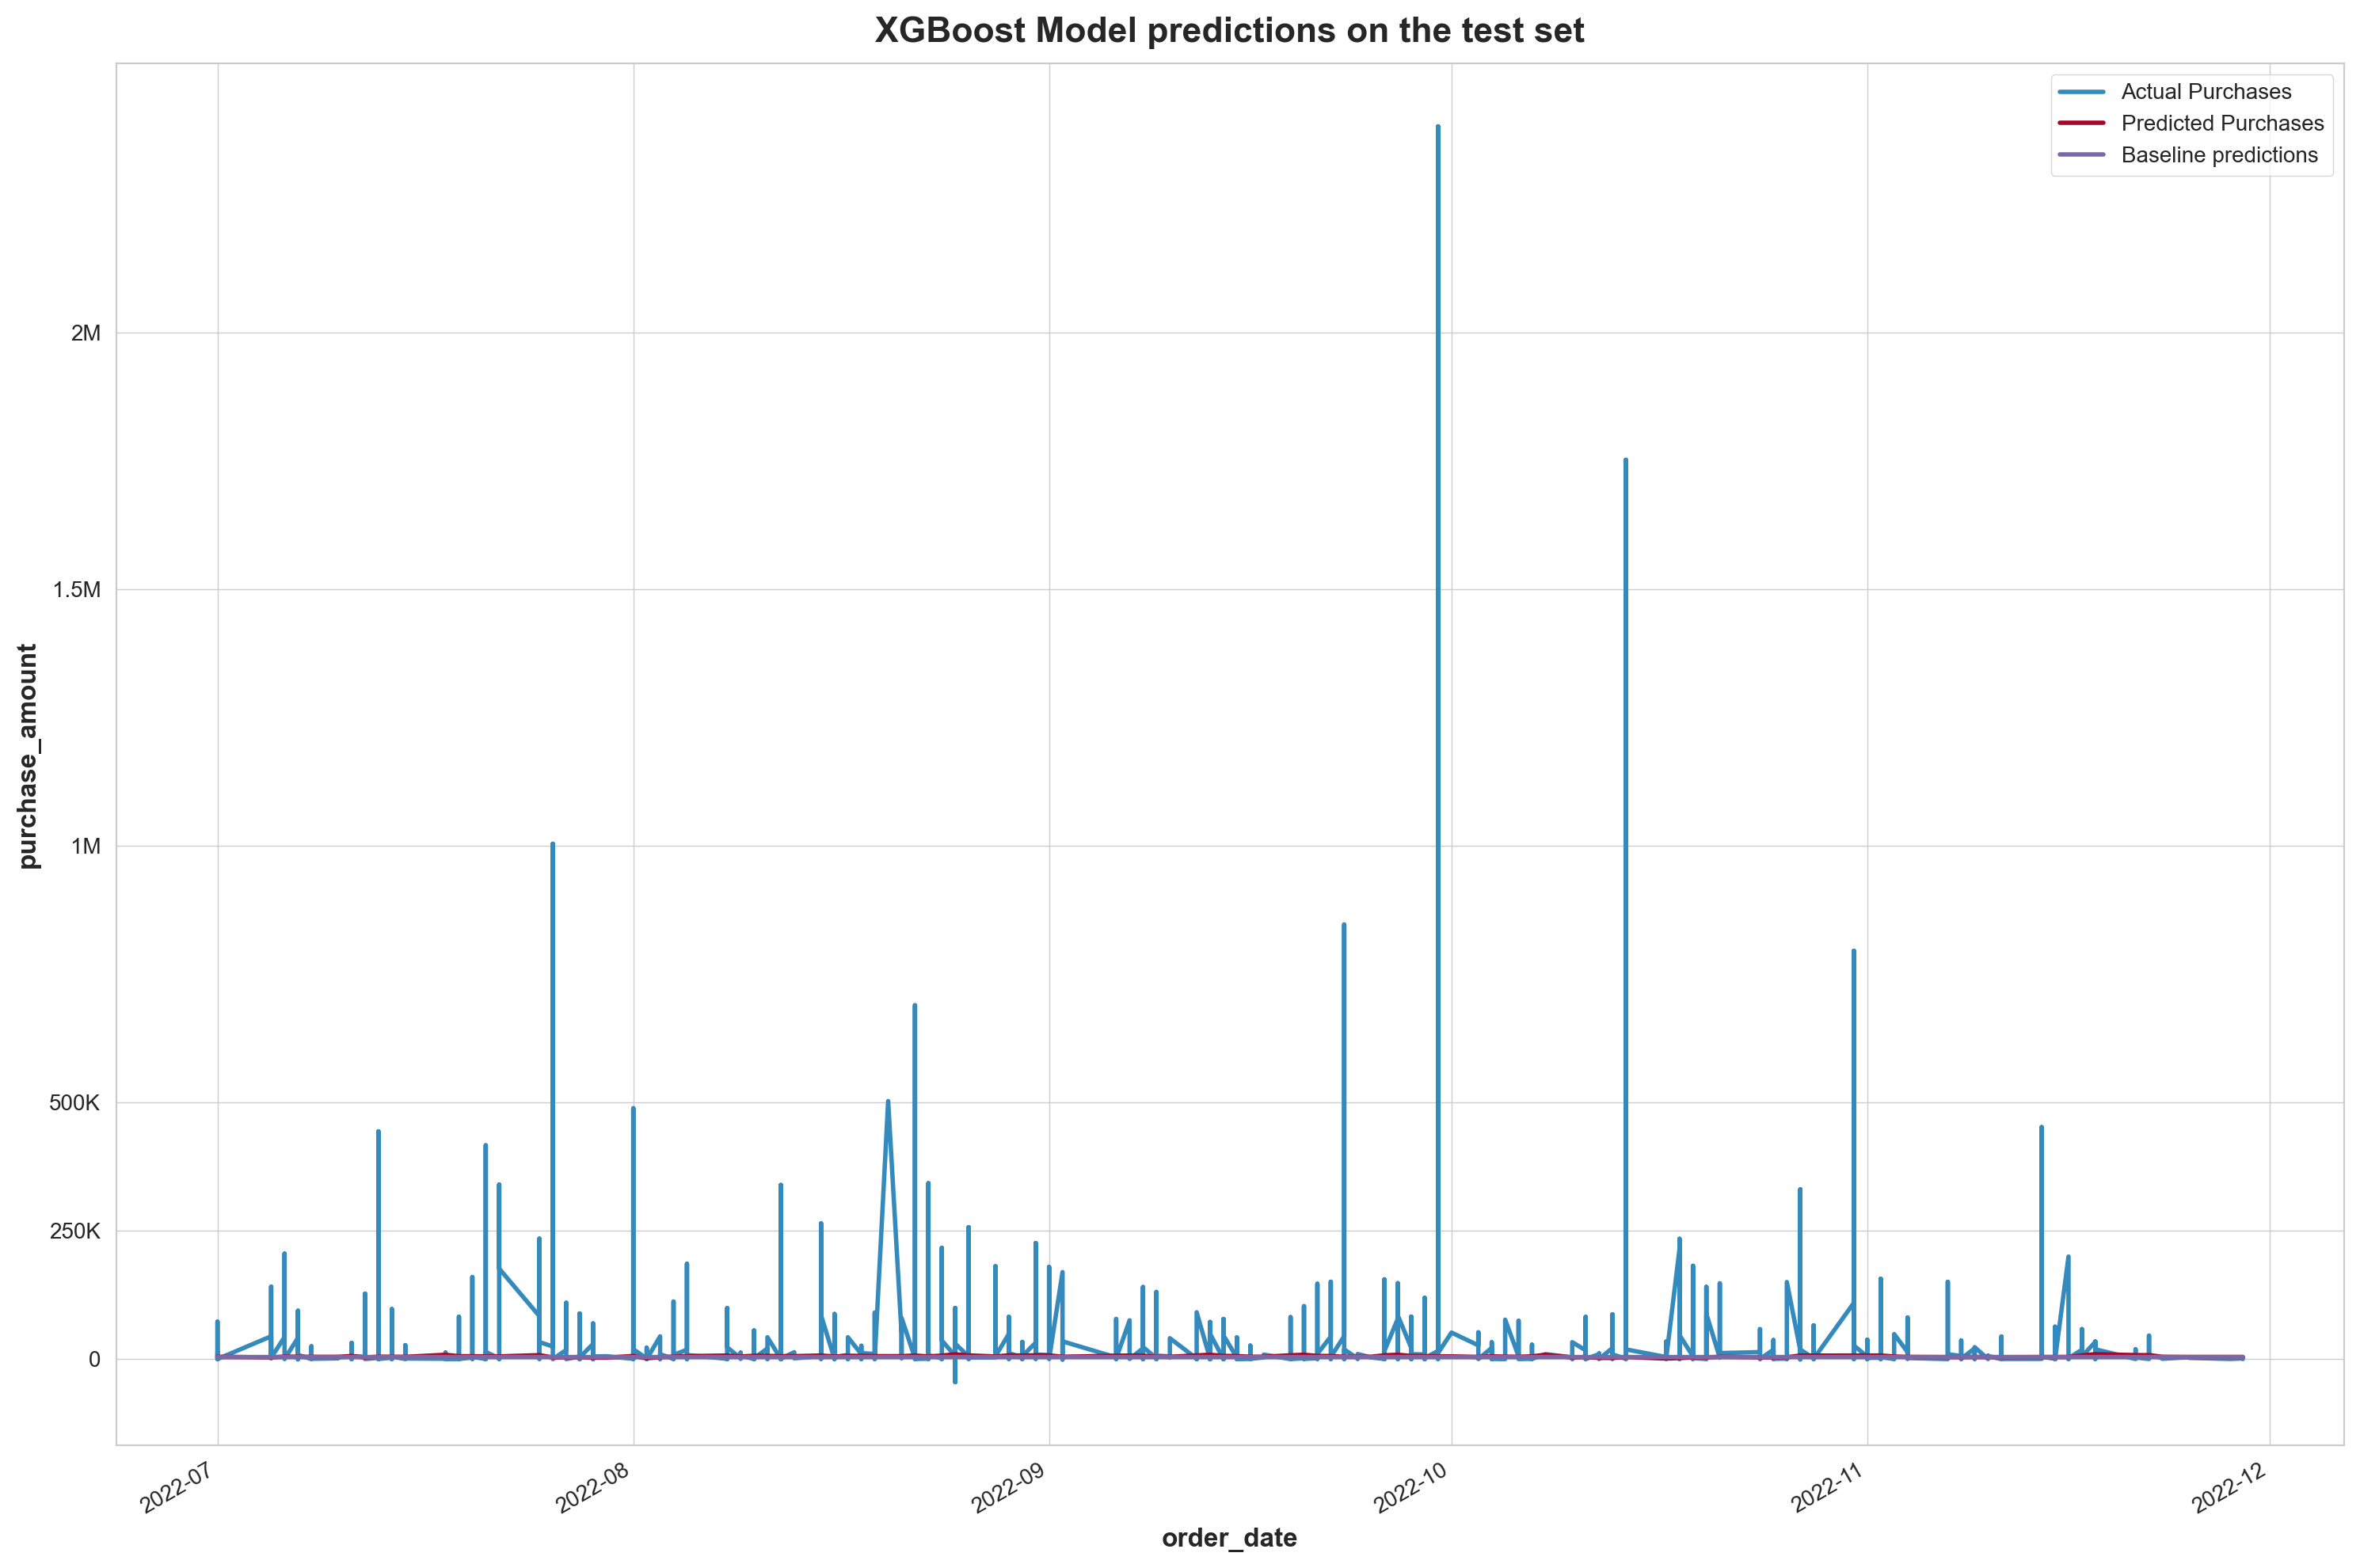

In [232]:
ax = test_df['actuals'].plot(figsize=(15,10), label='Actual Purchases', title='XGBoost Model predictions on the test set')
test_df['xgboost_regular_model_predictions'].plot(ax=ax, label='Predicted Purchases')
test_df['baseline_d_predictions'].plot(ax=ax, label='Baseline predictions')

plt.legend(['Actual Purchases', 'Predicted Purchases', 'Baseline predictions'])
ax.set(yticks=[0, 250_000, 500_000, 1_000_000, 1_500_000, 2_000_000])
ax.set(yticklabels=['0', '250K', '500K', '1M', '1.5M', '2M'])
ax.set(ylabel='purchase_amount')           
plt.show()